# Basic Usage
This notebook illustrates how the default pipeline can be used to compute xG values. This default pipeline is suitable for computing xG, but by no means the best possible model. 

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
from soccer_xg.api import DataApi
import soccer_xg.xg as xg
from soccer_xg.utils import sample_temporal

## Config

In [3]:
# dataset
dir_data = "../data"
provider = 'wyscout_opensource'
leagues = ['ENG', 'ESP', 'ITA', 'GER', 'FRA']
seasons = ['1718']

## Load the data
Make sure to run the `1-load-and-convert-wyscout-data` notebook first to download the data set and convert it to the SPADL format.

In [4]:
api = DataApi([f"{dir_data}/{provider}/spadl-{provider}-{l}-{s}.h5" 
        for (l,s) in itertools.product(leagues, seasons)])

## Model learning

First, create an instance of the default xG model. This is basically a wrapper around three seperate Scikit-learn pipelines (a seperate pipeline for open play shots, freekicks and penalties) for computing xG values.

In [7]:
model = xg.XGModel()

Once the modeling pipeline is set up, historical data needs to be fed into it in order to
"fit" the model so that it can then be used to predict future results.
This `train` method implements a simple wrapper around the core Scikit-learn functionality
which does this. We only use the data from ESP, ITA, FRA and GER to train the model. ENG is reserved for validating the model.

In [8]:
model.train(api, training_seasons=[('ESP', '1718'), ('ITA', '1718'), ('FRA', '1718'), ('GER', '1718')])

Generating labels: 100%|██████████| 1446/1446 [00:33<00:00, 43.78it/s]


Once a modeling pipeline is trained, a different dataset must be fed into the trained model
to validate the quality of the fit. Ideally, this validation set would consist out of more recent data from the same leagues as used for training. However, since the wyscout dataset contains only one season of data, we use the data from ENG to validate the model.

Generating features: 100%|██████████| 380/380 [00:11<00:00, 33.75it/s]
No handles with labels found to put in legend.


{'max_dev': 30.926317206053028,
 'residual_area': 823.2684757471029,
 'roc': 0.7871783922219415,
 'brier': 0.08585818466560044,
 'ece': 0.010637320991901903,
 'ace': 0.014368773223275452,
 'fig': <Figure size 720x360 with 3 Axes>}

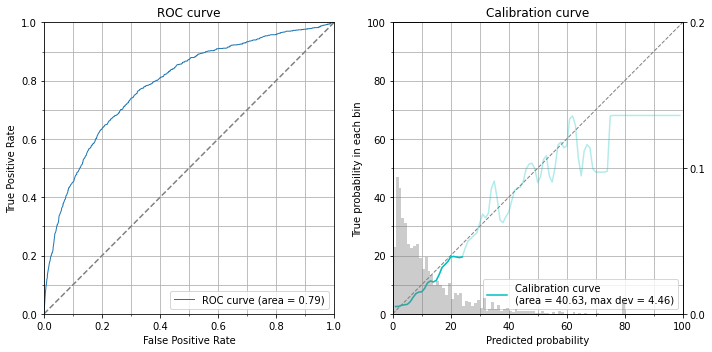

In [11]:
model.validate(api, validation_seasons=[('ENG', '1718')])

## Computing xG values

Once trained and validated, the model can be used to compute xG values. For example, the cell below computes the xG values of all shots in the 17/18 Premier League season.

In [12]:
games_eng_1718 = api.games[api.games.competition_id == 'ENG']
xg_eng_1718 = model.estimate(api, game_ids=games_eng_1718.index)

Generating features: 100%|██████████| 380/380 [00:10<00:00, 35.75it/s]


These can be aggregated to compute the total xG value of each player in the 17/18 season.

In [22]:
(xg_eng_1718
 # find player id for each shot
 .join(api.actions.set_index(['game_id', 'action_id']), how="left")
 # sum xG values for each player
 .groupby('player_id')[['xG']].sum()
 # find player name
 .join(api.players[['short_name']], how="left")
 # get top 10
 .sort_values(by='xG', ascending=False).head(n=10)
 # clean up the list
 .set_index('short_name', drop=True)
)

,xG
short_name,
H. Kane,28.714433
Mohamed Salah,22.768716
S. Agüero,18.095464
J. Vardy,17.587558
R. Lukaku,17.147181
R. Sterling,15.968029
A. Lacazette,14.283950
G. Murray,14.157180
Gabriel Jesus,13.436479
